# Analysis of combinatorial coding of identity (Fig 7)

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
# Gene expression
df = pd.read_csv("../data/df_GH146_Fig2.csv.gz", header=0, index_col=0)

# Cluster labels
df_labels = pd.read_csv("../data/labels_HDBSCAN.csv", sep="\t", header=0, index_col=0)

In [3]:
# Load names of TFs and CSM genes
def load_list(infile):
    X = []
    with open(infile) as f:
        for line in f:
            X.append(line.rstrip())
    return X

def write_list(X, outfile):
    with open(outfile, 'w') as out:
        for x in X:
            out.write(str(x) + "\n")

CSMs = load_list("../resources/CSMs.txt")
TFs = load_list("../resources/TFs.txt")
genes_genome_noTFs_noCSMs = list(set(list(df.index)) - set(TFs) - set(CSMs))

# Identification of combinatorial codes for cell identity using mutual information

# Discretize expression levels

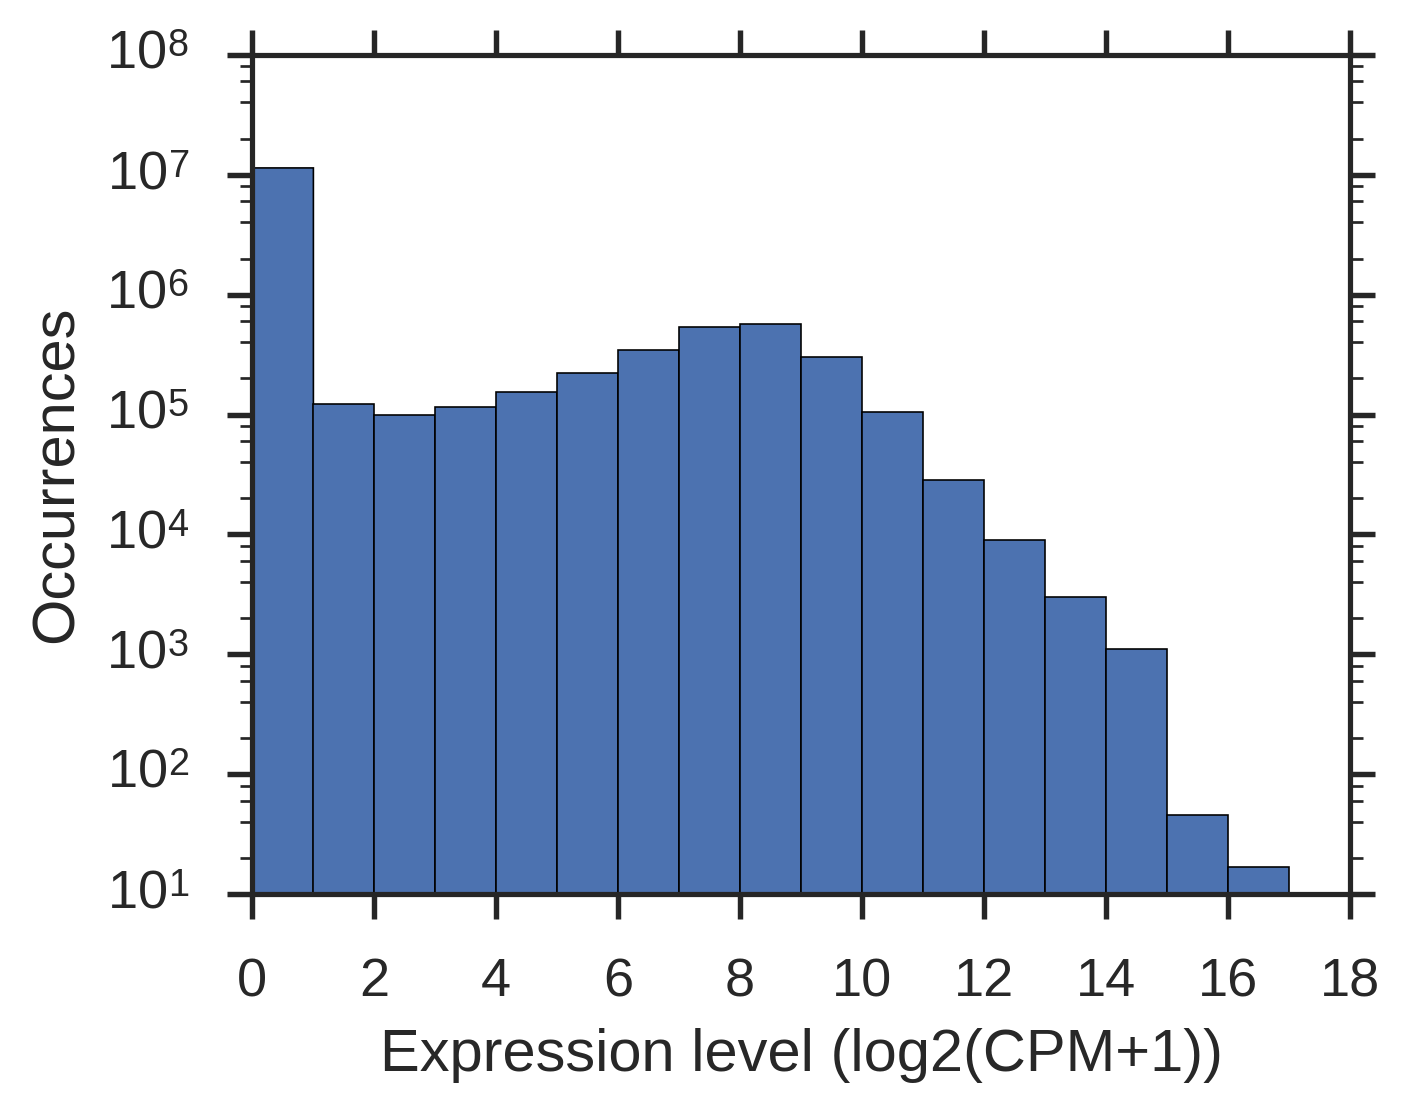

In [4]:
# Plot distribution of expression levels (for choosing discretization)
data = df.values.flatten()
bins = range(0,18)
fig, ax = plt.subplots(1, 1, figsize=(5,4))
ax.hist(data, bins=bins)
ax.set_yscale('log')
ax.set_xlabel("Expression level (log2(CPM+1))")
ax.set_ylabel("Occurrences")
plt.tight_layout()

# Choose cutoff for binarization at minimum (3)

In [5]:
# Discretize expression levels
bins = [0, 3, 18]
labels = ["Off", "On"]
df_discrete = pd.cut(df.values.flatten(), bins=bins, labels=labels, include_lowest=True)
df_discrete = pd.DataFrame(np.array(df_discrete).reshape(df.shape))
df_discrete.columns = df.columns
df_discrete["symbol"] = df.index
df_discrete.set_index("symbol", inplace=True)

# Train classifier: identify gene set with maximum mutual information with cluster identity

In [7]:
# Define functions for information theory analysis

# Compute mutual information between each gene and cluster assignment
from sklearn.metrics import mutual_info_score
def calc_mutual_information(df_discrete, labels):
    mutual_informations = []
    for symbol, row in df_discrete.iterrows():
        mi = mutual_info_score(row, labels) / np.log(2) # calculate mutual information, convert from nats to bits
        mutual_informations.append(mi)
    df_result = pd.DataFrame()
    df_result["symbol"] = df_discrete.index
    df_result.set_index("symbol", inplace=True)
    df_result["mutual_information"] = mutual_informations
    df_result.sort_values("mutual_information", inplace=True, ascending=False)
    return df_result

# Calculate mean expression of each gene within each cluster
def calc_summary_by_label(df, labels, summary_func=np.mean):
    df_temp = copy.deepcopy(df.T)
    df_temp["label"] = labels
    df_summary_by_label = df_temp.groupby("label").aggregate(summary_func).T
    del df_temp
    return df_summary_by_label

# Calculate total information of a gene set
def calc_cumulative_information_of_set(df_discrete, genes, df_labels):
    """ Calculates total information of gene set """
    # Entropy of class without knowledge of genes
    H_naive = scipy.stats.entropy(df_labels["label"].value_counts(normalize=True), base=2)
    # Get discretized gene expression matrix with only selected genes
    df_temp = df_discrete.loc[genes].T

    H = 0
    # Find unique combinations of expression levels
    for _, row in df_temp.drop_duplicates().iterrows():
        cell_names = df_temp.index[np.all(df_temp == row, axis=1)] # Get cell names having this unique combination of expression levels
        labels_cond = df_labels.loc[cell_names]["label"] # Get class labels of cells
        # Calculate entropy of classification (conditional on expression levels)
        H_cond = scipy.stats.entropy(labels_cond.value_counts(normalize=True), base=2)
        weight = len(cell_names) / df_temp.shape[0] # Weight by fraction of cells in this set
        H += H_cond*weight

    I = H_naive - H
    return I

# Calculate total information for each gene set defined by iteratively adding a single gene
# starting from the beginning of the list genes
def calc_cumulative_informations(df_discrete, genes, df_labels, N=5):
    """ Calculates total information of gene sets starting from top of df """
    cis = []
    for i in range(0,N):
        my_ci = calc_cumulative_information_of_set(df_discrete, genes[:i+1], df_labels)
        cis.append(my_ci)
    cis = np.array(cis)
    df_result = pd.DataFrame()
    df_result["symbol"] = genes
    df_result.set_index("symbol", inplace=True)
    df_result["cumulative_mutual_information"] = ""
    df_result["cumulative_mutual_information"] = np.nan
    df_result["cumulative_mutual_information"].loc[genes[:N]] = cis
    return df_result

# Define function to pick non-redundant genes

def find_nonredundant_gene_set(df_discrete, genes,
                               df_labels,
                               df_info,
                               H_naive,
                               N_constrain=20,
                               cumulative_information_cutoff=0.99,
                               verbose=False):
        
    cis = []
    nonredundant_genes = []
    current_ci = 0
    current_relative_ci = 0.0
    
    # Rank genes by mutual information
    remaining_genes = list(df_info.loc[genes]["mutual_information"].sort_values(ascending=False).head(n=N_constrain).index)
    
    i = 0
    
    while True:
        
        i +=1
        
        # Calculate information gain for each gene
        df_info_gains = pd.DataFrame(index=list(remaining_genes))
        my_info_gains = []
        
        for gene in remaining_genes:
            my_genes = nonredundant_genes + [gene]
            my_ci = calc_cumulative_information_of_set(df_discrete, my_genes, df_labels)
            my_info_gain = my_ci - current_ci
            my_info_gains.append(my_info_gain)
        
        df_info_gains["info_gain"] = my_info_gains
        
        # Sort genes by information gain
        df_info_gains.sort_values("info_gain", ascending=False, inplace=True)
        
        # Take best gene
        hit = df_info_gains["info_gain"].index[0]
        
        nonredundant_genes.append(hit)
        remaining_genes.remove(hit)
        current_ci = current_ci + df_info_gains.iloc[0]["info_gain"]
        current_relative_ci = current_ci / H_naive
        
        if verbose:
            print hit
            print current_relative_ci
            print
        
        if len(remaining_genes) == 0 or current_relative_ci > cumulative_information_cutoff:
            return nonredundant_genes
        
def head_threshold(df, threshold, field="relative_cumulative_information"):
    L = max(np.where(df[field] <= threshold)[0])+2
    print L
    return df.iloc[:L]

In [8]:
### Train classifier

# Compute mutual information between each gene and cluster assignment
df_info = calc_mutual_information(df_discrete, df_labels["label"])

# Calculate median expression of each gene within each cluster
df_expr_labels = calc_summary_by_label(df, df_labels["label"], summary_func=np.median)

# Calculate relative cumulative information
# Entropy of classification without gene expression data
H_naive = scipy.stats.entropy(df_labels["label"].value_counts(normalize=True), base=2)
print "Total entropy of classification", H_naive, "bits"

Total entropy of classification 4.51456791675 bits


In [9]:
# Find non-redundant gene set (genome-wide)
genes_nonredundant = find_nonredundant_gene_set(df_discrete, df_info.head(n=30).index,
                                                df_labels, df_info, H_naive,
                                                N_constrain=30,
                                                cumulative_information_cutoff=0.99,
                                                verbose=False)
print genes_nonredundant

['kn', 'CG17278', 'C15', 'otp', 'dati', 'twz', 'pdm3', 'br', 'unpg', 'caup', 'DIP-eta', 'CG11317', 'CG31814', 'fru', 'CG2082']


In [10]:
# Calculate relative cumulative information with increasingly large codes

df_info_nonredundant = df_info.copy()

# Calculate cumulative information for top N genes
cumulative_informations = calc_cumulative_informations(df_discrete, genes_nonredundant,
                                                       df_labels, N=len(genes_nonredundant))
df_info_nonredundant["cumulative_information"] = cumulative_informations["cumulative_mutual_information"]

# Calculate information relative to total entropy
relative_cumulative_informations = df_info_nonredundant["cumulative_information"] / H_naive
df_info_nonredundant["relative_cumulative_information"] = relative_cumulative_informations

df_info_nonredundant.sort_values("relative_cumulative_information", inplace=True)

In [11]:
# Prune to minimal code (having > 0.95 cumulative information)
genes_nonredundant_minimal = list(head_threshold(df_info_nonredundant, 0.95).index)

11


In [12]:
# Peek at minimal set
df_info_nonredundant.head(len(genes_nonredundant_minimal))

,mutual_information,cumulative_information,relative_cumulative_information
symbol,,,
kn,0.874236,0.874236,0.193648
CG17278,0.728366,1.581931,0.350406
C15,0.849491,2.236419,0.495378
otp,0.725962,2.852054,0.631745
dati,0.610776,3.241941,0.718106
twz,0.542207,3.547009,0.785681
pdm3,0.763618,3.806941,0.843257
br,0.510715,3.995768,0.885083
unpg,0.579197,4.141385,0.917338


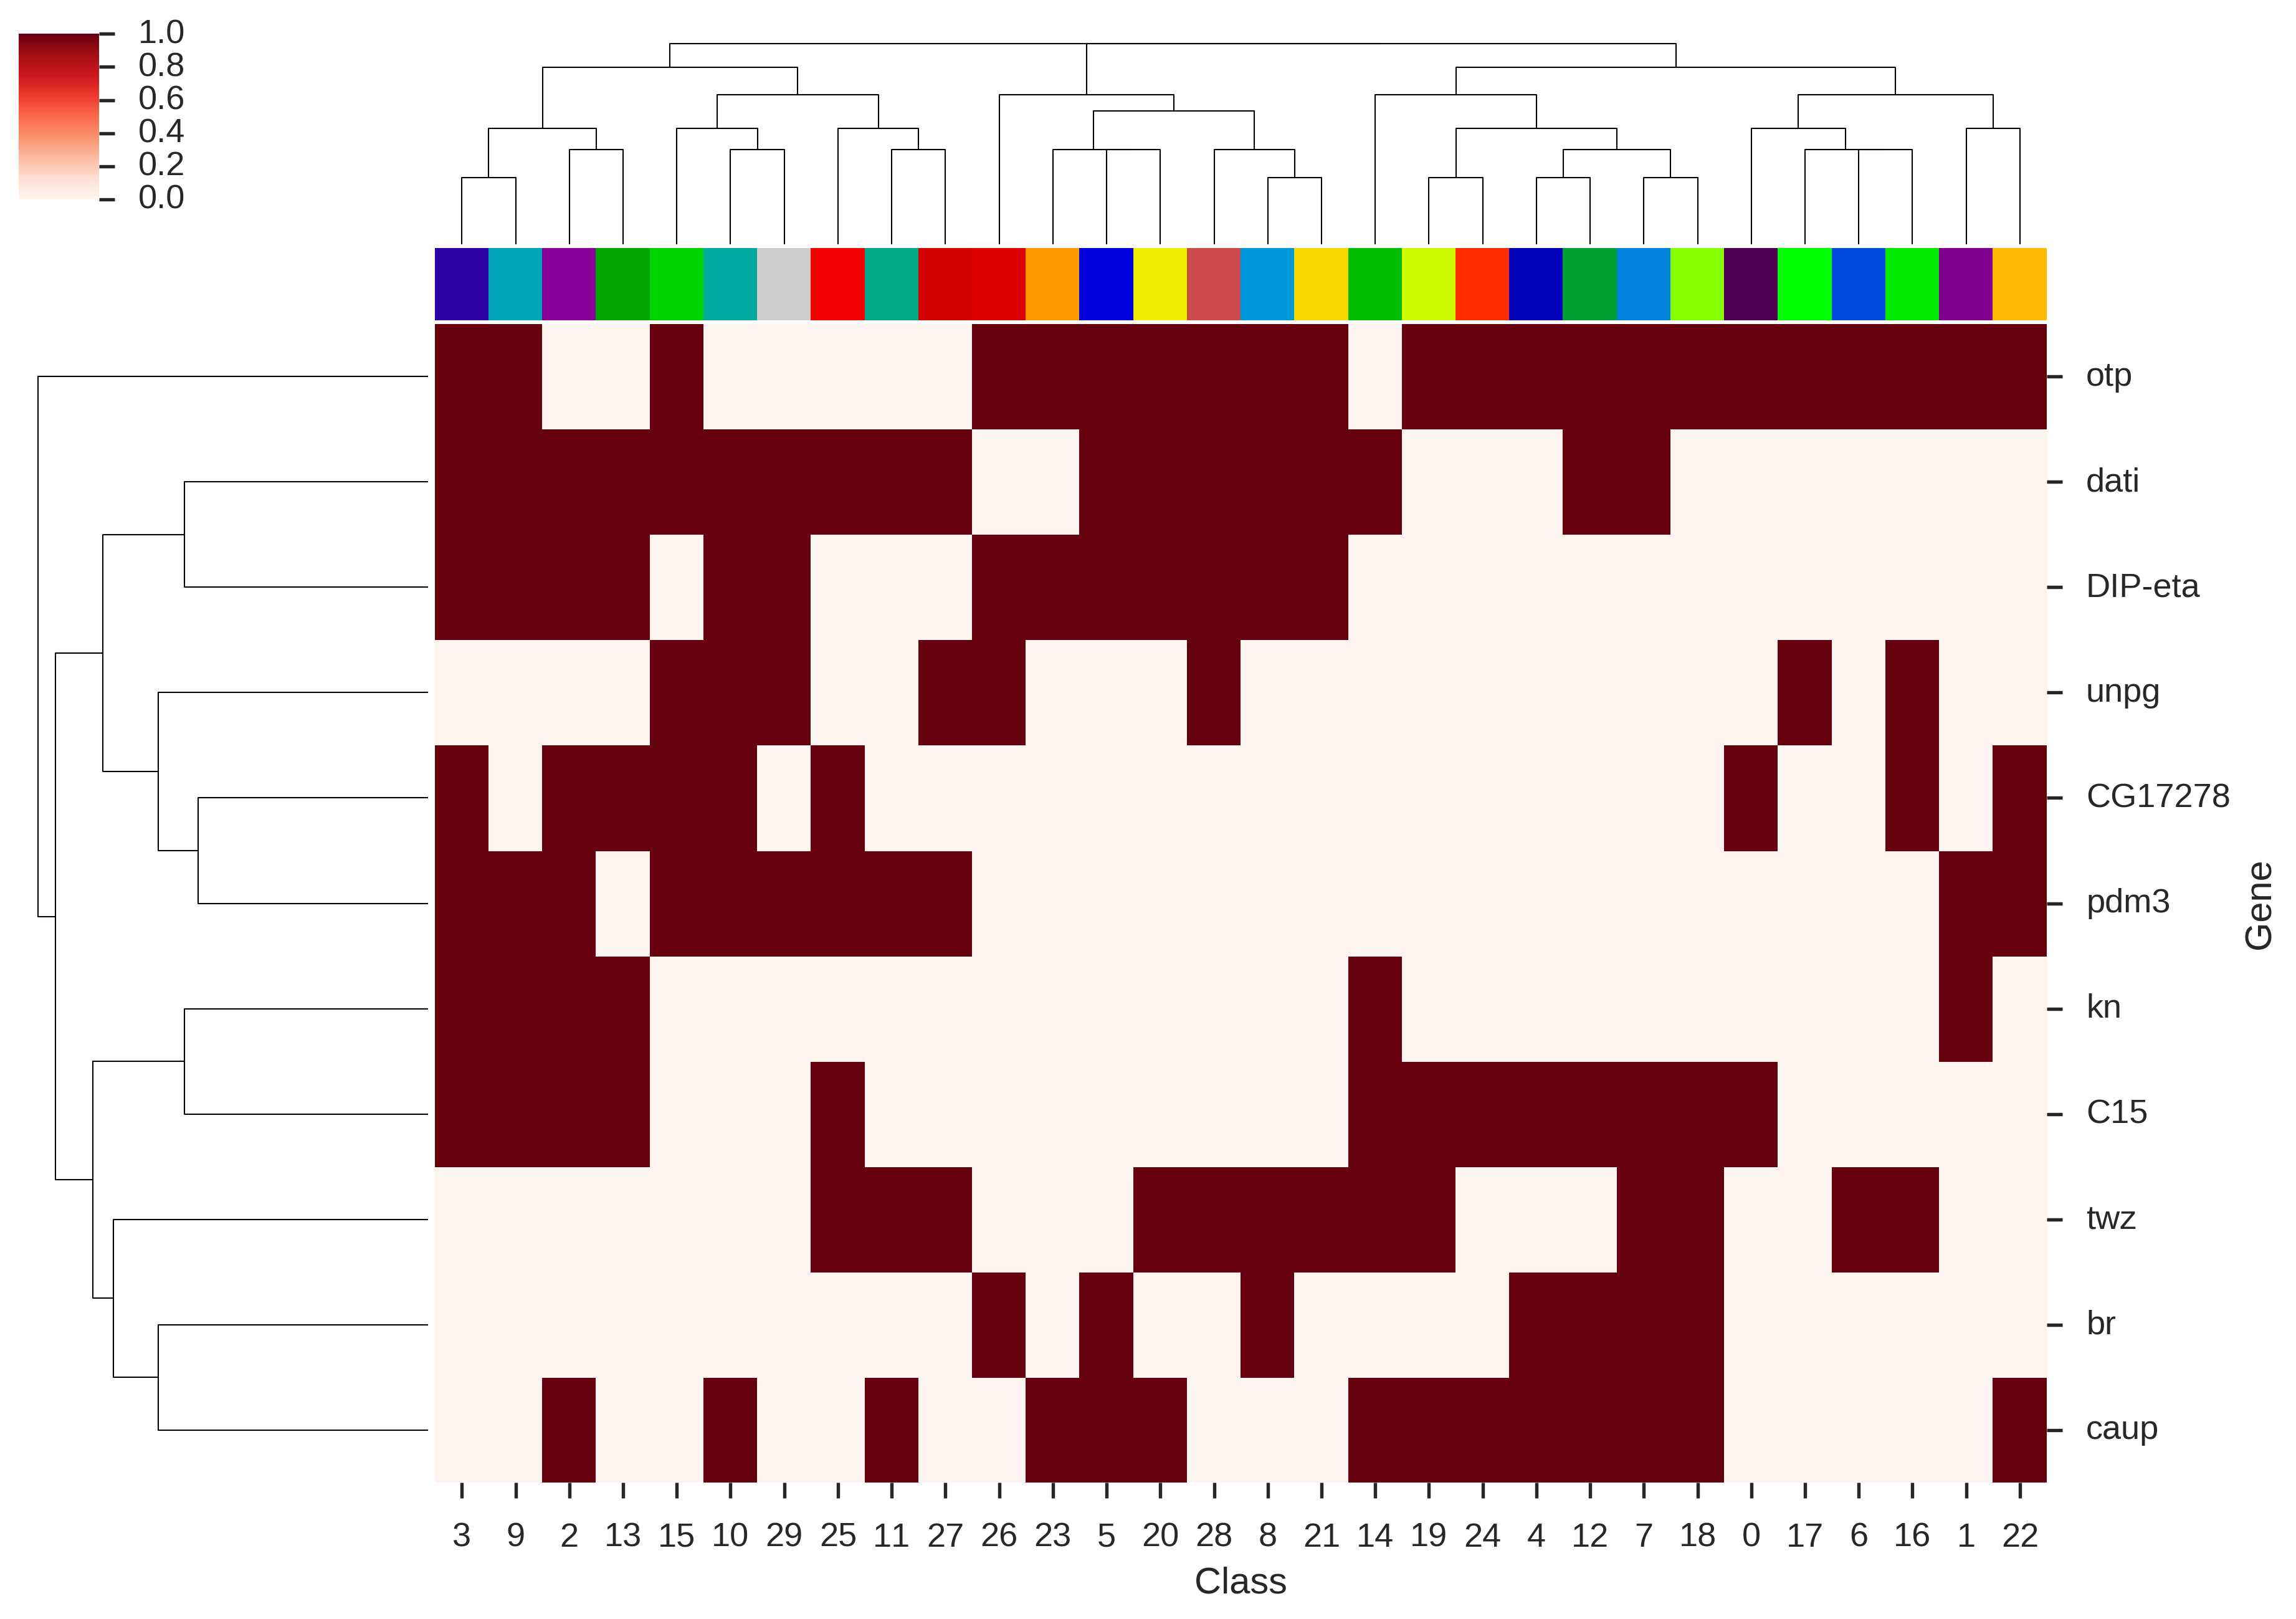

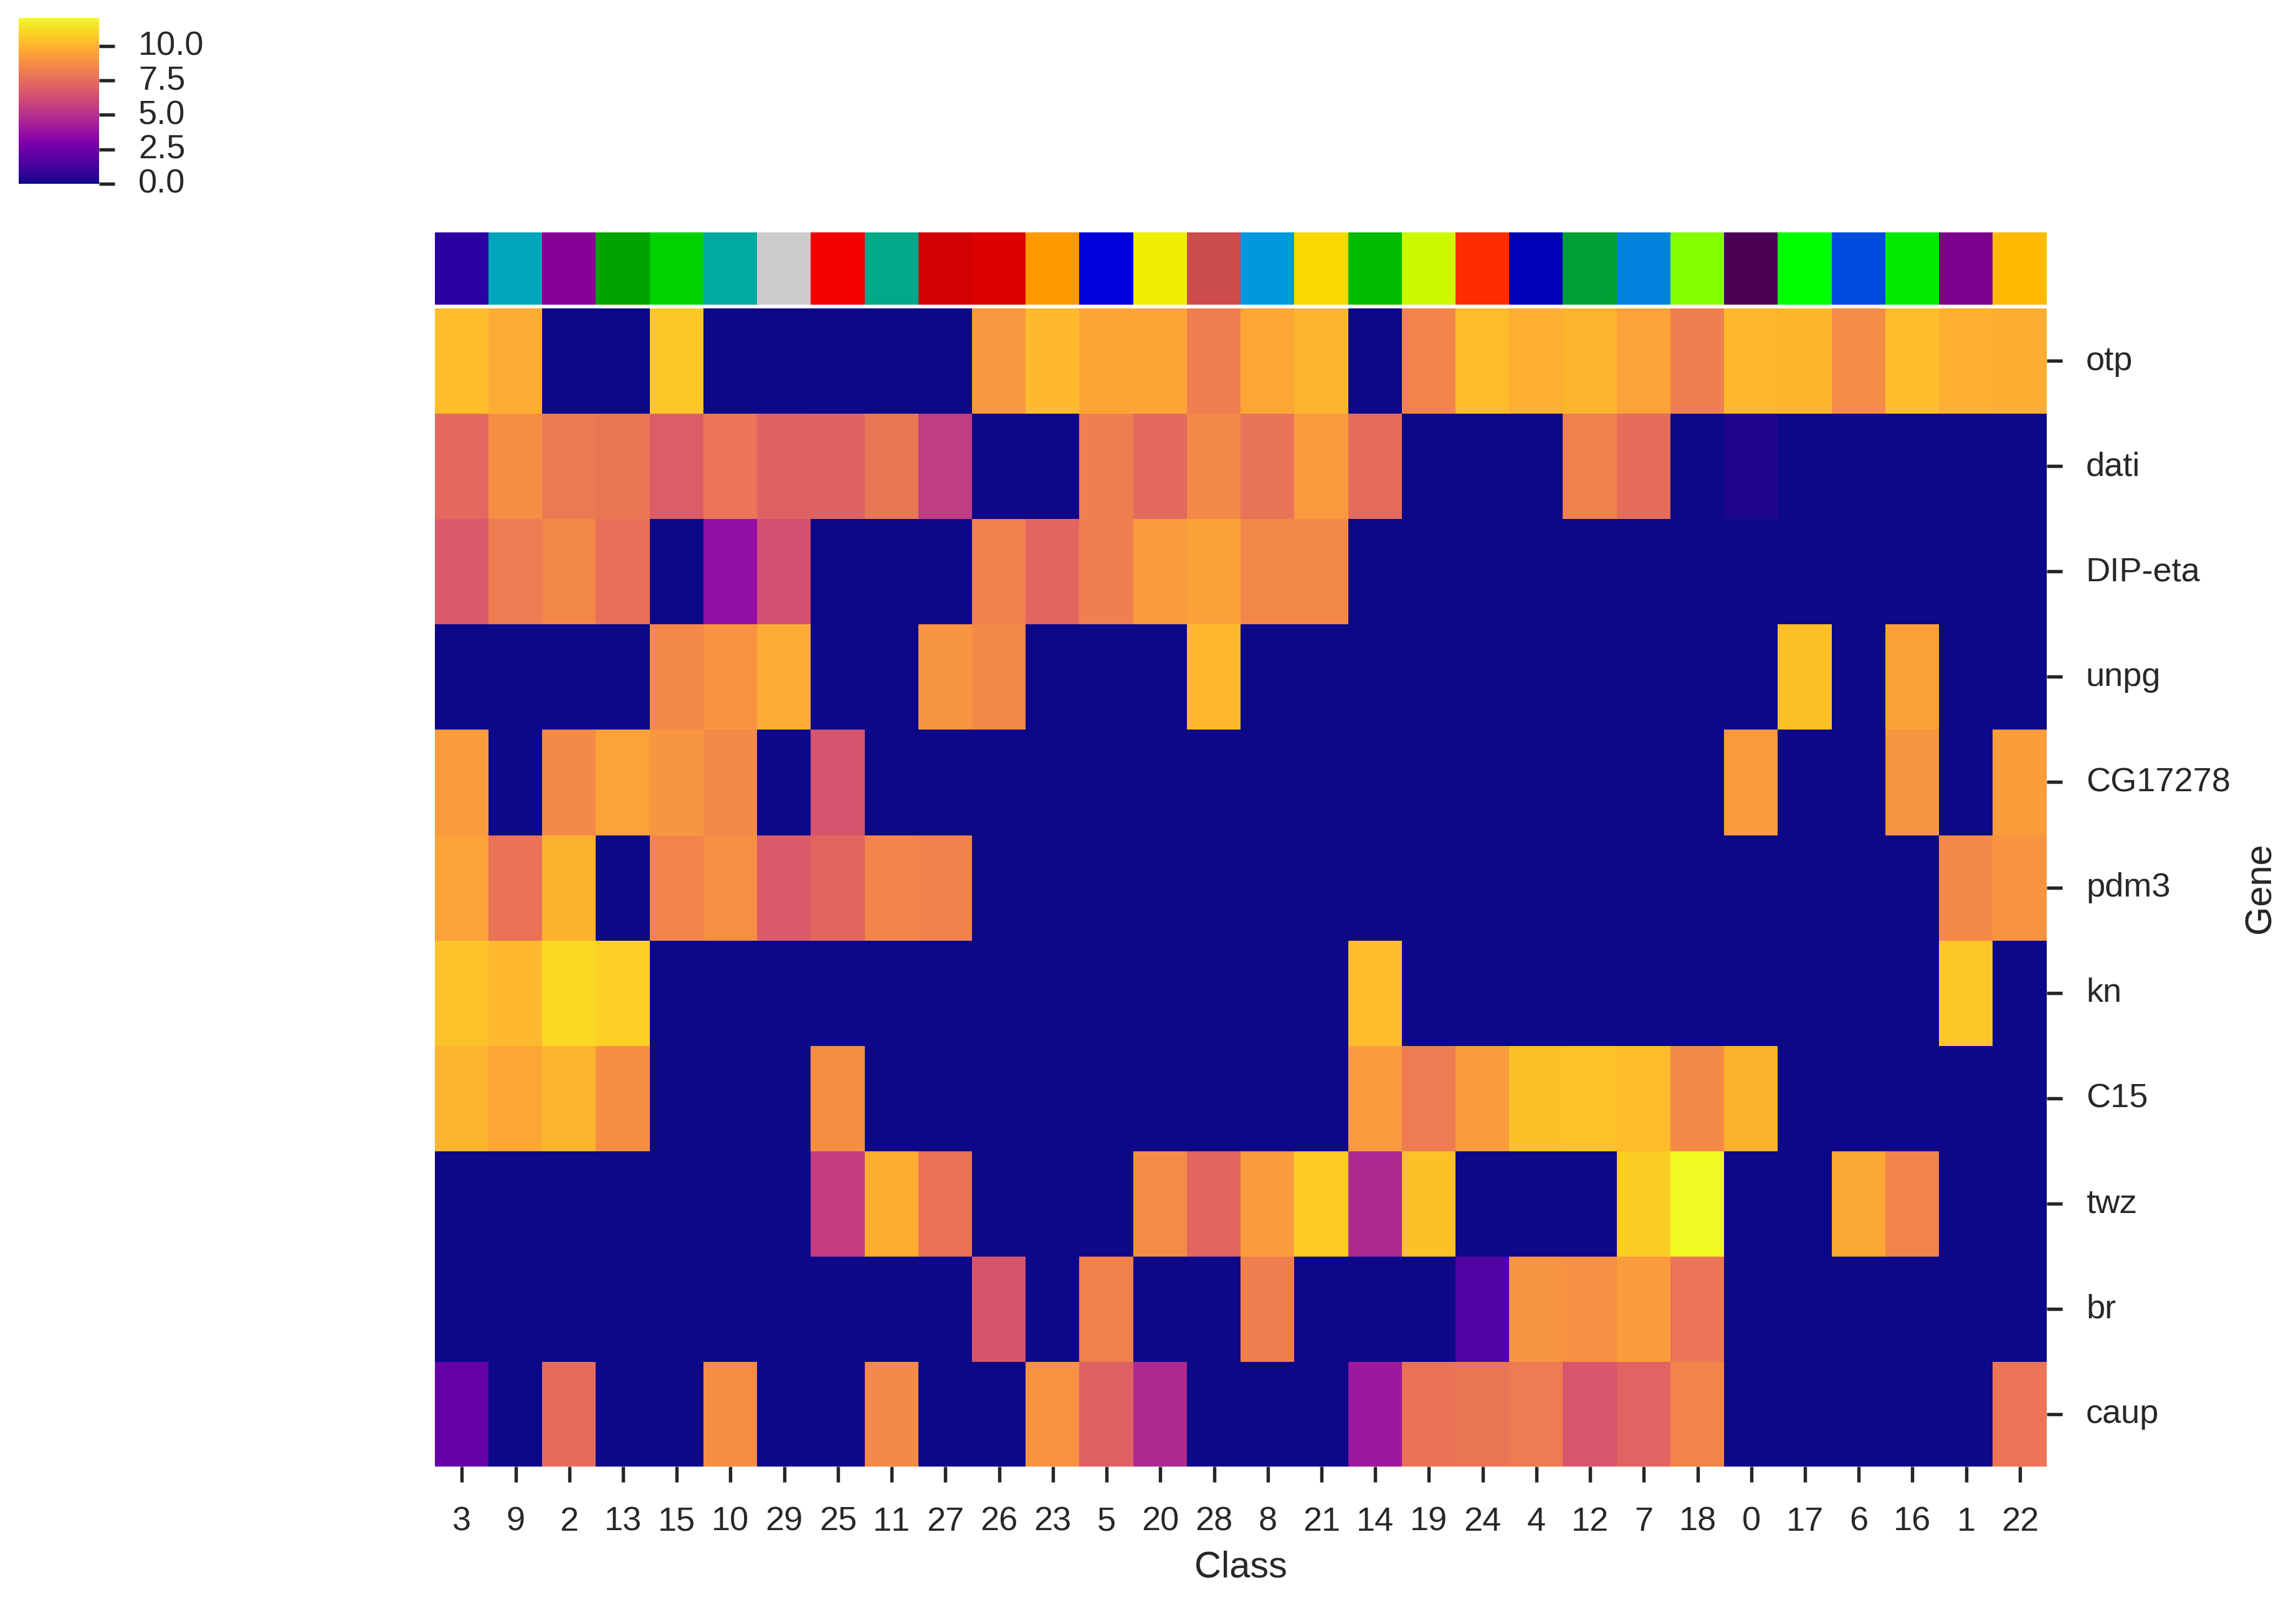

In [13]:
# Plot clustermaps of minimal set

data = df_expr_labels.loc[genes_nonredundant_minimal]
data = data.drop(-1, axis=1)

cmap = mpl.cm.get_cmap("nipy_spectral")
norm = mpl.colors.Normalize(vmin=min(df_labels["label"]), vmax=max(df_labels["label"]))
col_colors = [cmap(norm(x)) for x in list(data.columns)]

# Discrete
data_discrete = data > 3
cm = sns.clustermap(data=data_discrete, cmap="Reds", figsize=(14,10),
                    method="complete",
                    col_colors=col_colors)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_xlabel("Class")
cm.ax_heatmap.set_ylabel("Gene")

# Continuous, ordered same way
data_reordered = data.iloc[cm.dendrogram_row.reordered_ind, cm.dendrogram_col.reordered_ind]
col_colors = [cmap(norm(x)) for x in list(data_reordered.columns)]

cm = sns.clustermap(data=data_reordered, cmap="plasma", figsize=(14,10),
                    method="complete", row_cluster=False, col_cluster=False,
                    col_colors=col_colors)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_xlabel("Class")
cm.ax_heatmap.set_ylabel("Gene")

In [14]:
print "non-redundant genes", len(genes_nonredundant_minimal)
print "TFs", len([x for x in genes_nonredundant_minimal if x in TFs])
print "CSMs", len([x for x in genes_nonredundant_minimal if x in CSMs])

non-redundant genes 11
TFs 8
CSMs 1


# TFs, CSMs

In [15]:
# Calculate cumulative information for TFs
genes_top_TFs = df_info.loc[TFs].sort_values("mutual_information", ascending=False).index
df_info_TFs = calc_cumulative_informations(df_discrete, genes_top_TFs, df_labels, N=20)
relative_cumulative_informations_TFs = df_info_TFs["cumulative_mutual_information"] / H_naive
df_info_TFs["relative_cumulative_information"] = relative_cumulative_informations_TFs

In [16]:
genes_nonredundant_TFs = find_nonredundant_gene_set(df_discrete, df_info_TFs.head(n=30).index,
                                                df_labels, df_info, H_naive,
                                                N_constrain=30,
                                                cumulative_information_cutoff=0.99,
                                                verbose=False)
print genes_nonredundant_TFs

['kn', 'otp', 'C15', 'dati', 'caup', 'pdm3', 'bab2', 'br', 'CG11317', 'ara', 'unpg', 'danr', 'Lmpt', 'CG3726', 'NK7.1', 'ab', 'Eip93F', 'CG9650', 'rn', 'vvl']


In [17]:
# Calculate cumulative information for non-redundant TFs and CSMs
df_info_nonredundant_TFs = calc_cumulative_informations(df_discrete, genes_nonredundant_TFs, df_labels, N=len(genes_nonredundant_TFs))
relative_cumulative_informations_nonredundant_TFs = df_info_nonredundant_TFs["cumulative_mutual_information"] / H_naive
df_info_nonredundant_TFs["relative_cumulative_information"] = relative_cumulative_informations_nonredundant_TFs
df_info_nonredundant_TFs.sort_values("relative_cumulative_information", inplace=True)

# Prune to minimal code (having > 0.95 cumulative information)
genes_nonredundant_TFs_minimal = list(head_threshold(df_info_nonredundant_TFs, 0.95).index)

13


In [18]:
# Peek at minimal set
df_info_nonredundant_TFs.head(len(genes_nonredundant_TFs_minimal))

,cumulative_mutual_information,relative_cumulative_information
symbol,,
kn,0.874236,0.193648
otp,1.537242,0.340507
C15,2.164068,0.479352
dati,2.610680,0.578279
caup,3.039279,0.673216
pdm3,3.352841,0.742671
bab2,3.594916,0.796292
br,3.792141,0.839979
CG11317,3.950524,0.875061


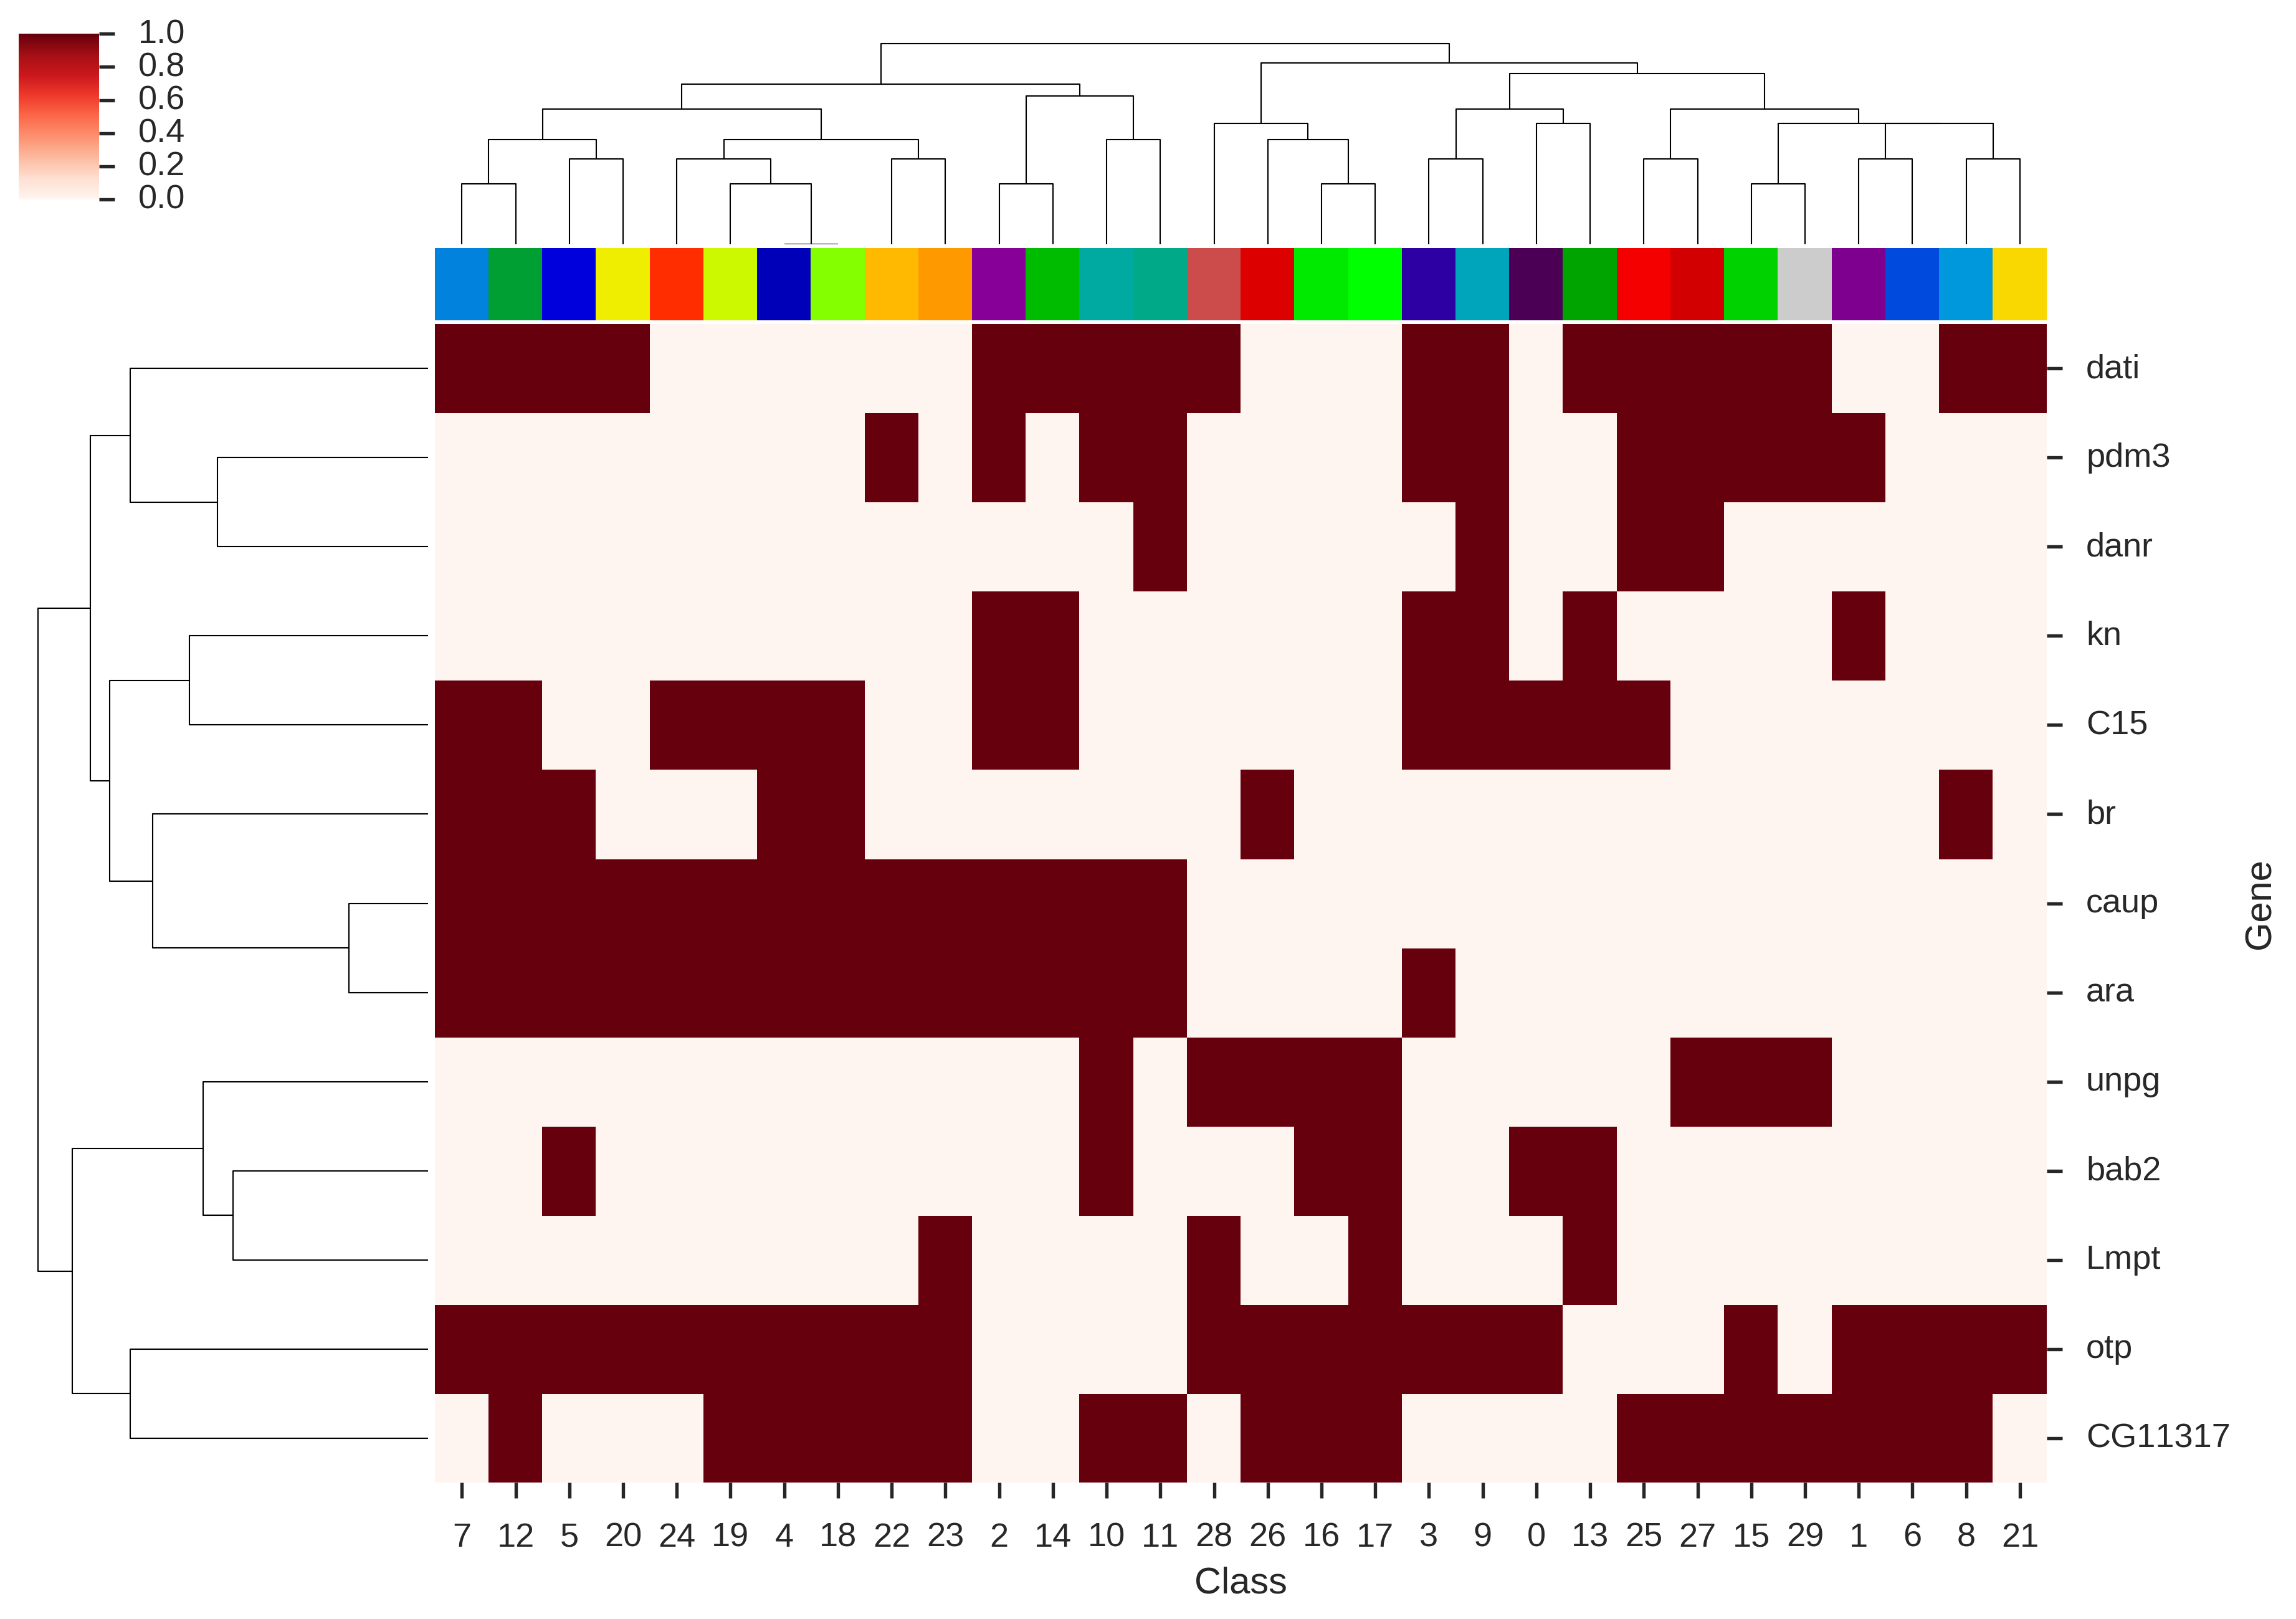

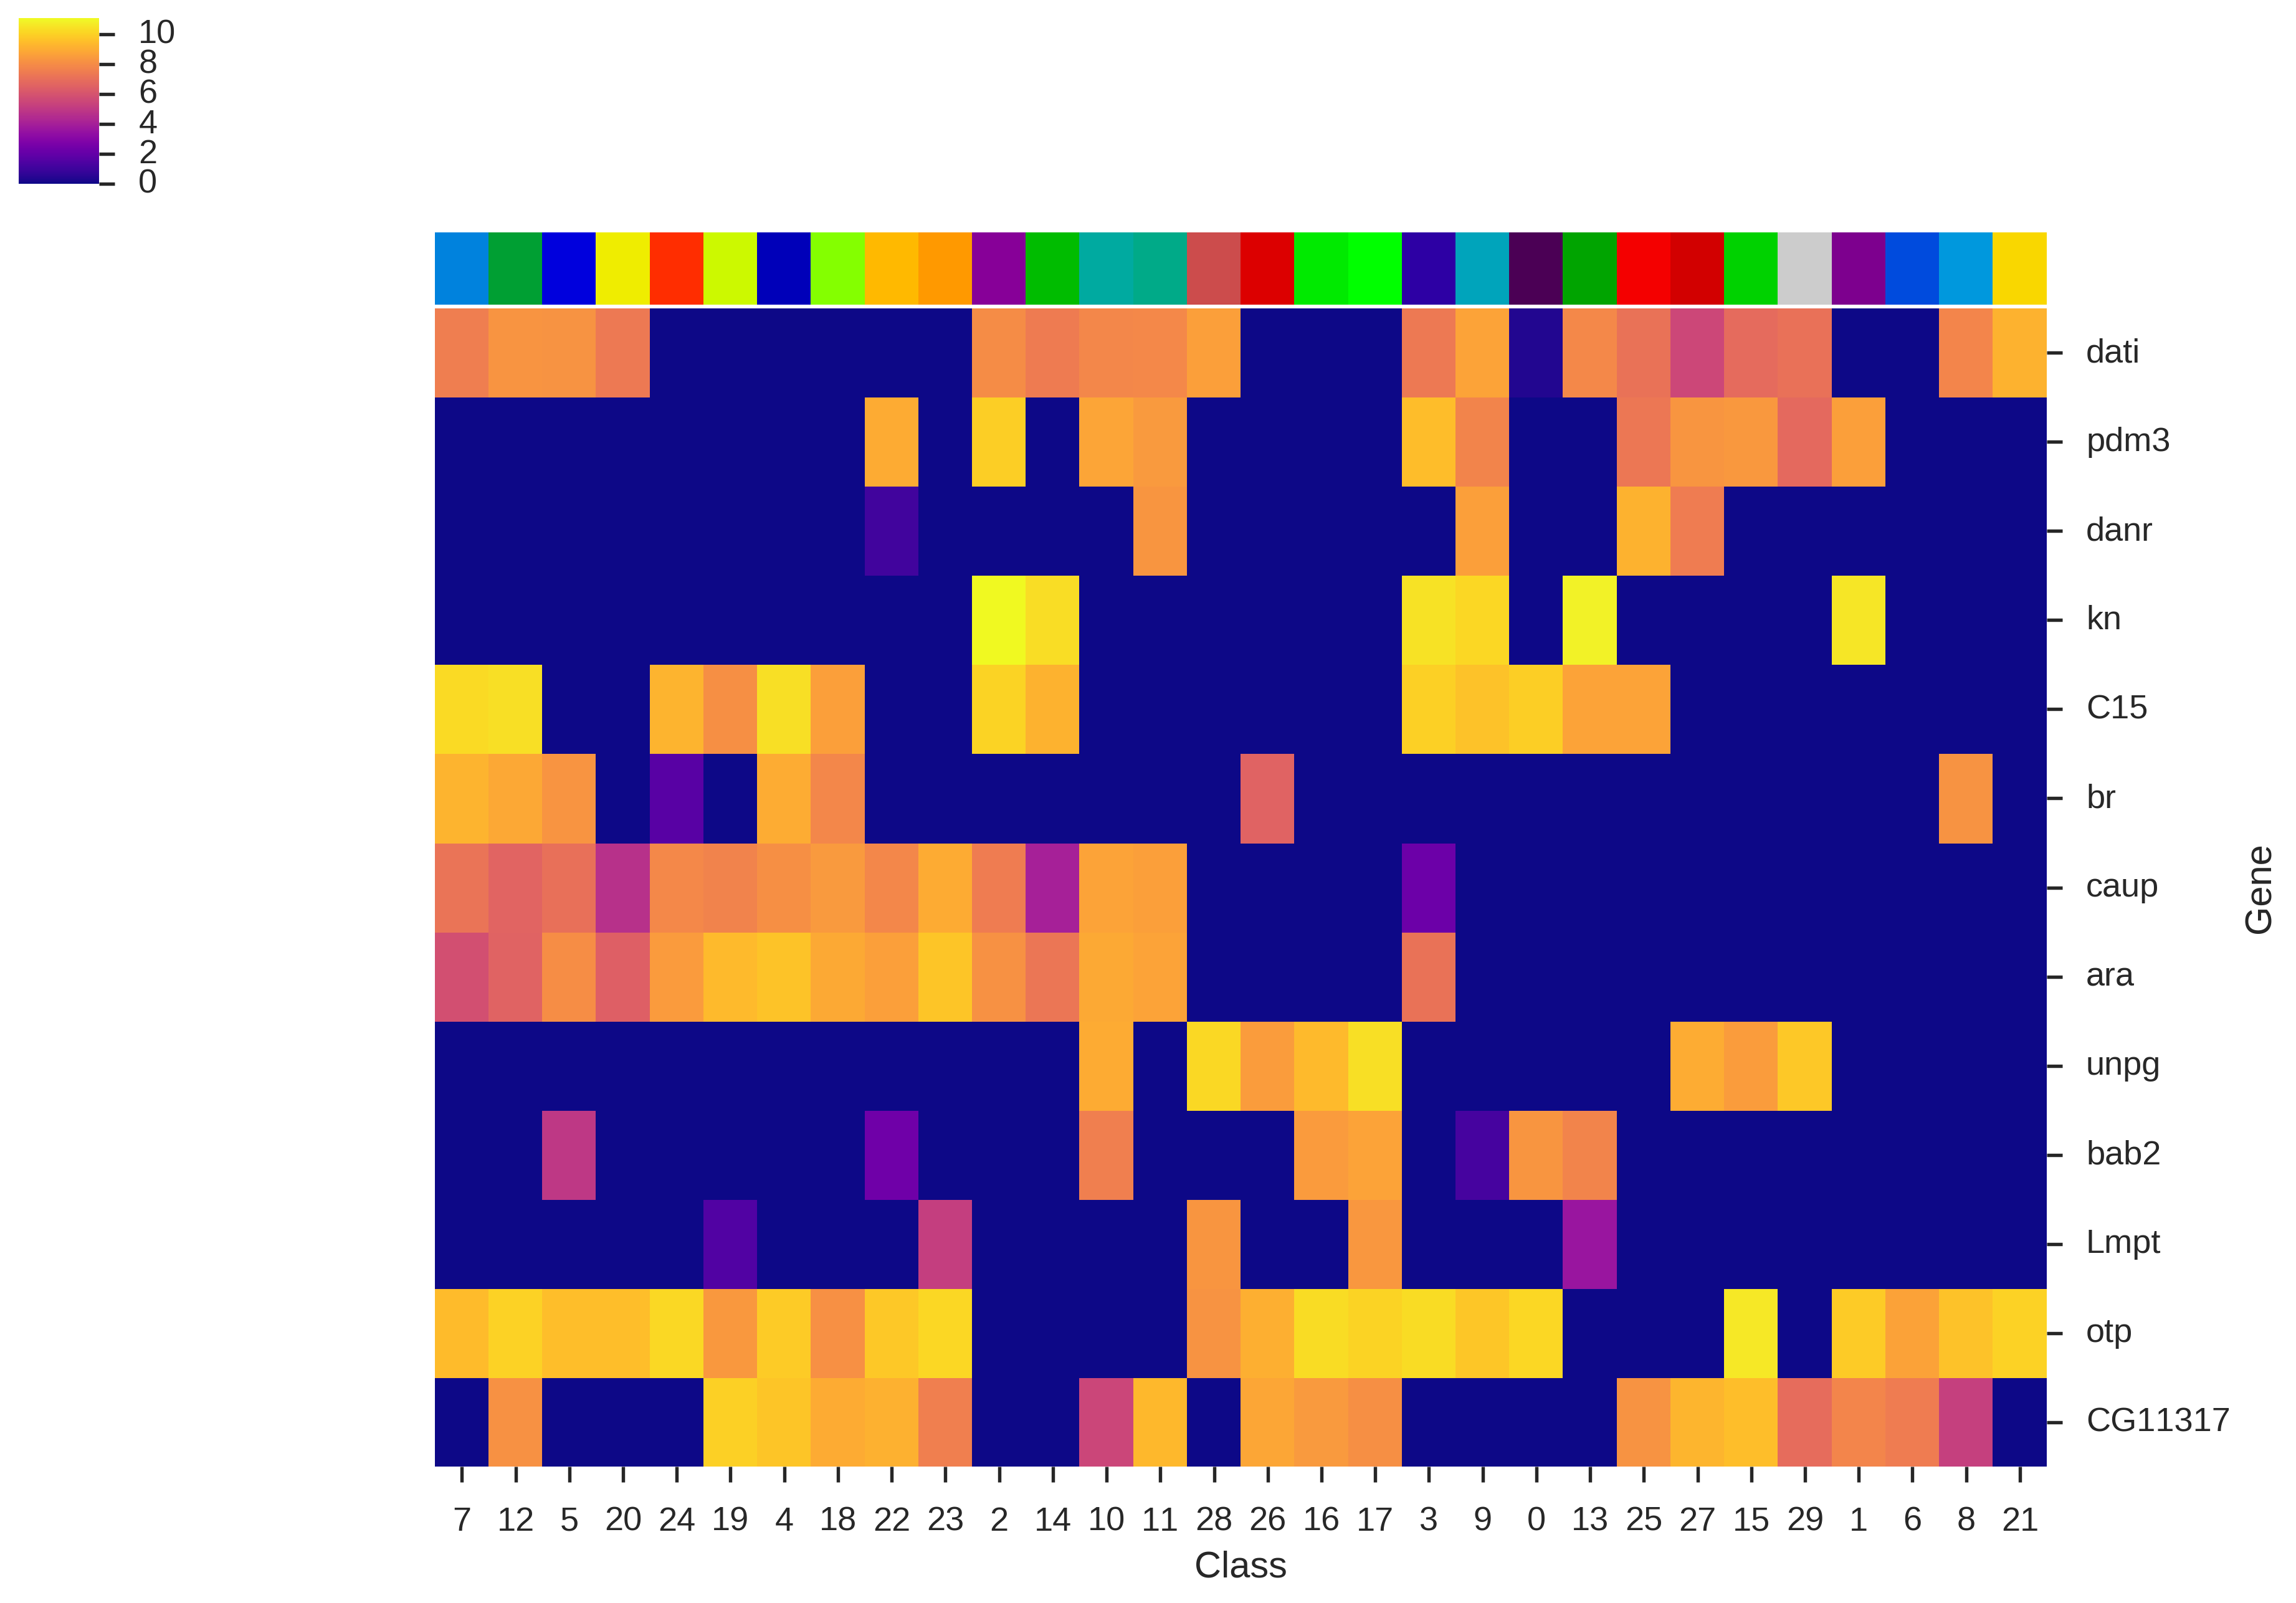

In [19]:
# Minimal set of TFs

data = df_expr_labels.loc[genes_nonredundant_TFs_minimal]
data = data.drop(-1, axis=1)

cmap = mpl.cm.get_cmap("nipy_spectral")
norm = mpl.colors.Normalize(vmin=min(df_labels["label"]), vmax=max(df_labels["label"]))
col_colors = [cmap(norm(x)) for x in list(data.columns)]

# Discrete
data_discrete = data > 3
cm = sns.clustermap(data=data_discrete, cmap="Reds", figsize=(14,10),
                    method="complete",
                    col_colors=col_colors)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_xlabel("Class")
cm.ax_heatmap.set_ylabel("Gene")

# Continuous, ordered same way
data_reordered = data.iloc[cm.dendrogram_row.reordered_ind, cm.dendrogram_col.reordered_ind]
col_colors = [cmap(norm(x)) for x in list(data_reordered.columns)]

cm = sns.clustermap(data=data_reordered, cmap="plasma", figsize=(14,10),
                    method="complete", row_cluster=False, col_cluster=False,
                    col_colors=col_colors)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_xlabel("Class")
cm.ax_heatmap.set_ylabel("Gene")

# CSMs

In [20]:
# Calculate cumulative information for CSMs
genes_top_CSMs = df_info.loc[CSMs].sort_values("mutual_information", ascending=False).index
df_info_CSMs = calc_cumulative_informations(df_discrete, genes_top_CSMs, df_labels, N=20)
relative_cumulative_informations_CSMs = df_info_CSMs["cumulative_mutual_information"] / H_naive
df_info_CSMs["relative_cumulative_information"] = relative_cumulative_informations_CSMs

genes_nonredundant_CSMs = find_nonredundant_gene_set(df_discrete, df_info_CSMs.head(n=30).index,
                                                df_labels, df_info, H_naive,
                                                N_constrain=30,
                                                cumulative_information_cutoff=0.99,
                                                verbose=False)
print genes_nonredundant_CSMs

# Calculate cumulative information for non-redundant CSMs and CSMs
df_info_nonredundant_CSMs = calc_cumulative_informations(df_discrete, genes_nonredundant_CSMs, df_labels, N=len(genes_nonredundant_CSMs))
relative_cumulative_informations_nonredundant_CSMs = df_info_nonredundant_CSMs["cumulative_mutual_information"] / H_naive
df_info_nonredundant_CSMs["relative_cumulative_information"] = relative_cumulative_informations_nonredundant_CSMs
df_info_nonredundant_CSMs.sort_values("relative_cumulative_information", inplace=True)

# Prune to minimal code (having > 0.95 cumulative information)
genes_nonredundant_CSMs_minimal = list(head_threshold(df_info_nonredundant_CSMs, 0.95).index)

# Peek at minimal set
df_info_nonredundant_CSMs.head(len(genes_nonredundant_CSMs_minimal))

['DIP-eta', 'Con', 'CG31814', 'robo3', 'klg', 'CG34353', 'CG45263', 'beat-VI', 'CG33543', 'CG10650', 'Octbeta1R', 'Pxn', 'CG12484', 'dpr12']
12


,cumulative_mutual_information,relative_cumulative_information
symbol,,
DIP-eta,0.552146,0.122303
Con,1.022492,0.226487
CG31814,1.479037,0.327614
robo3,1.933822,0.428351
klg,2.365781,0.524033
CG34353,2.787483,0.617442
CG45263,3.167507,0.701619
beat-VI,3.506736,0.776760
CG33543,3.823762,0.846983


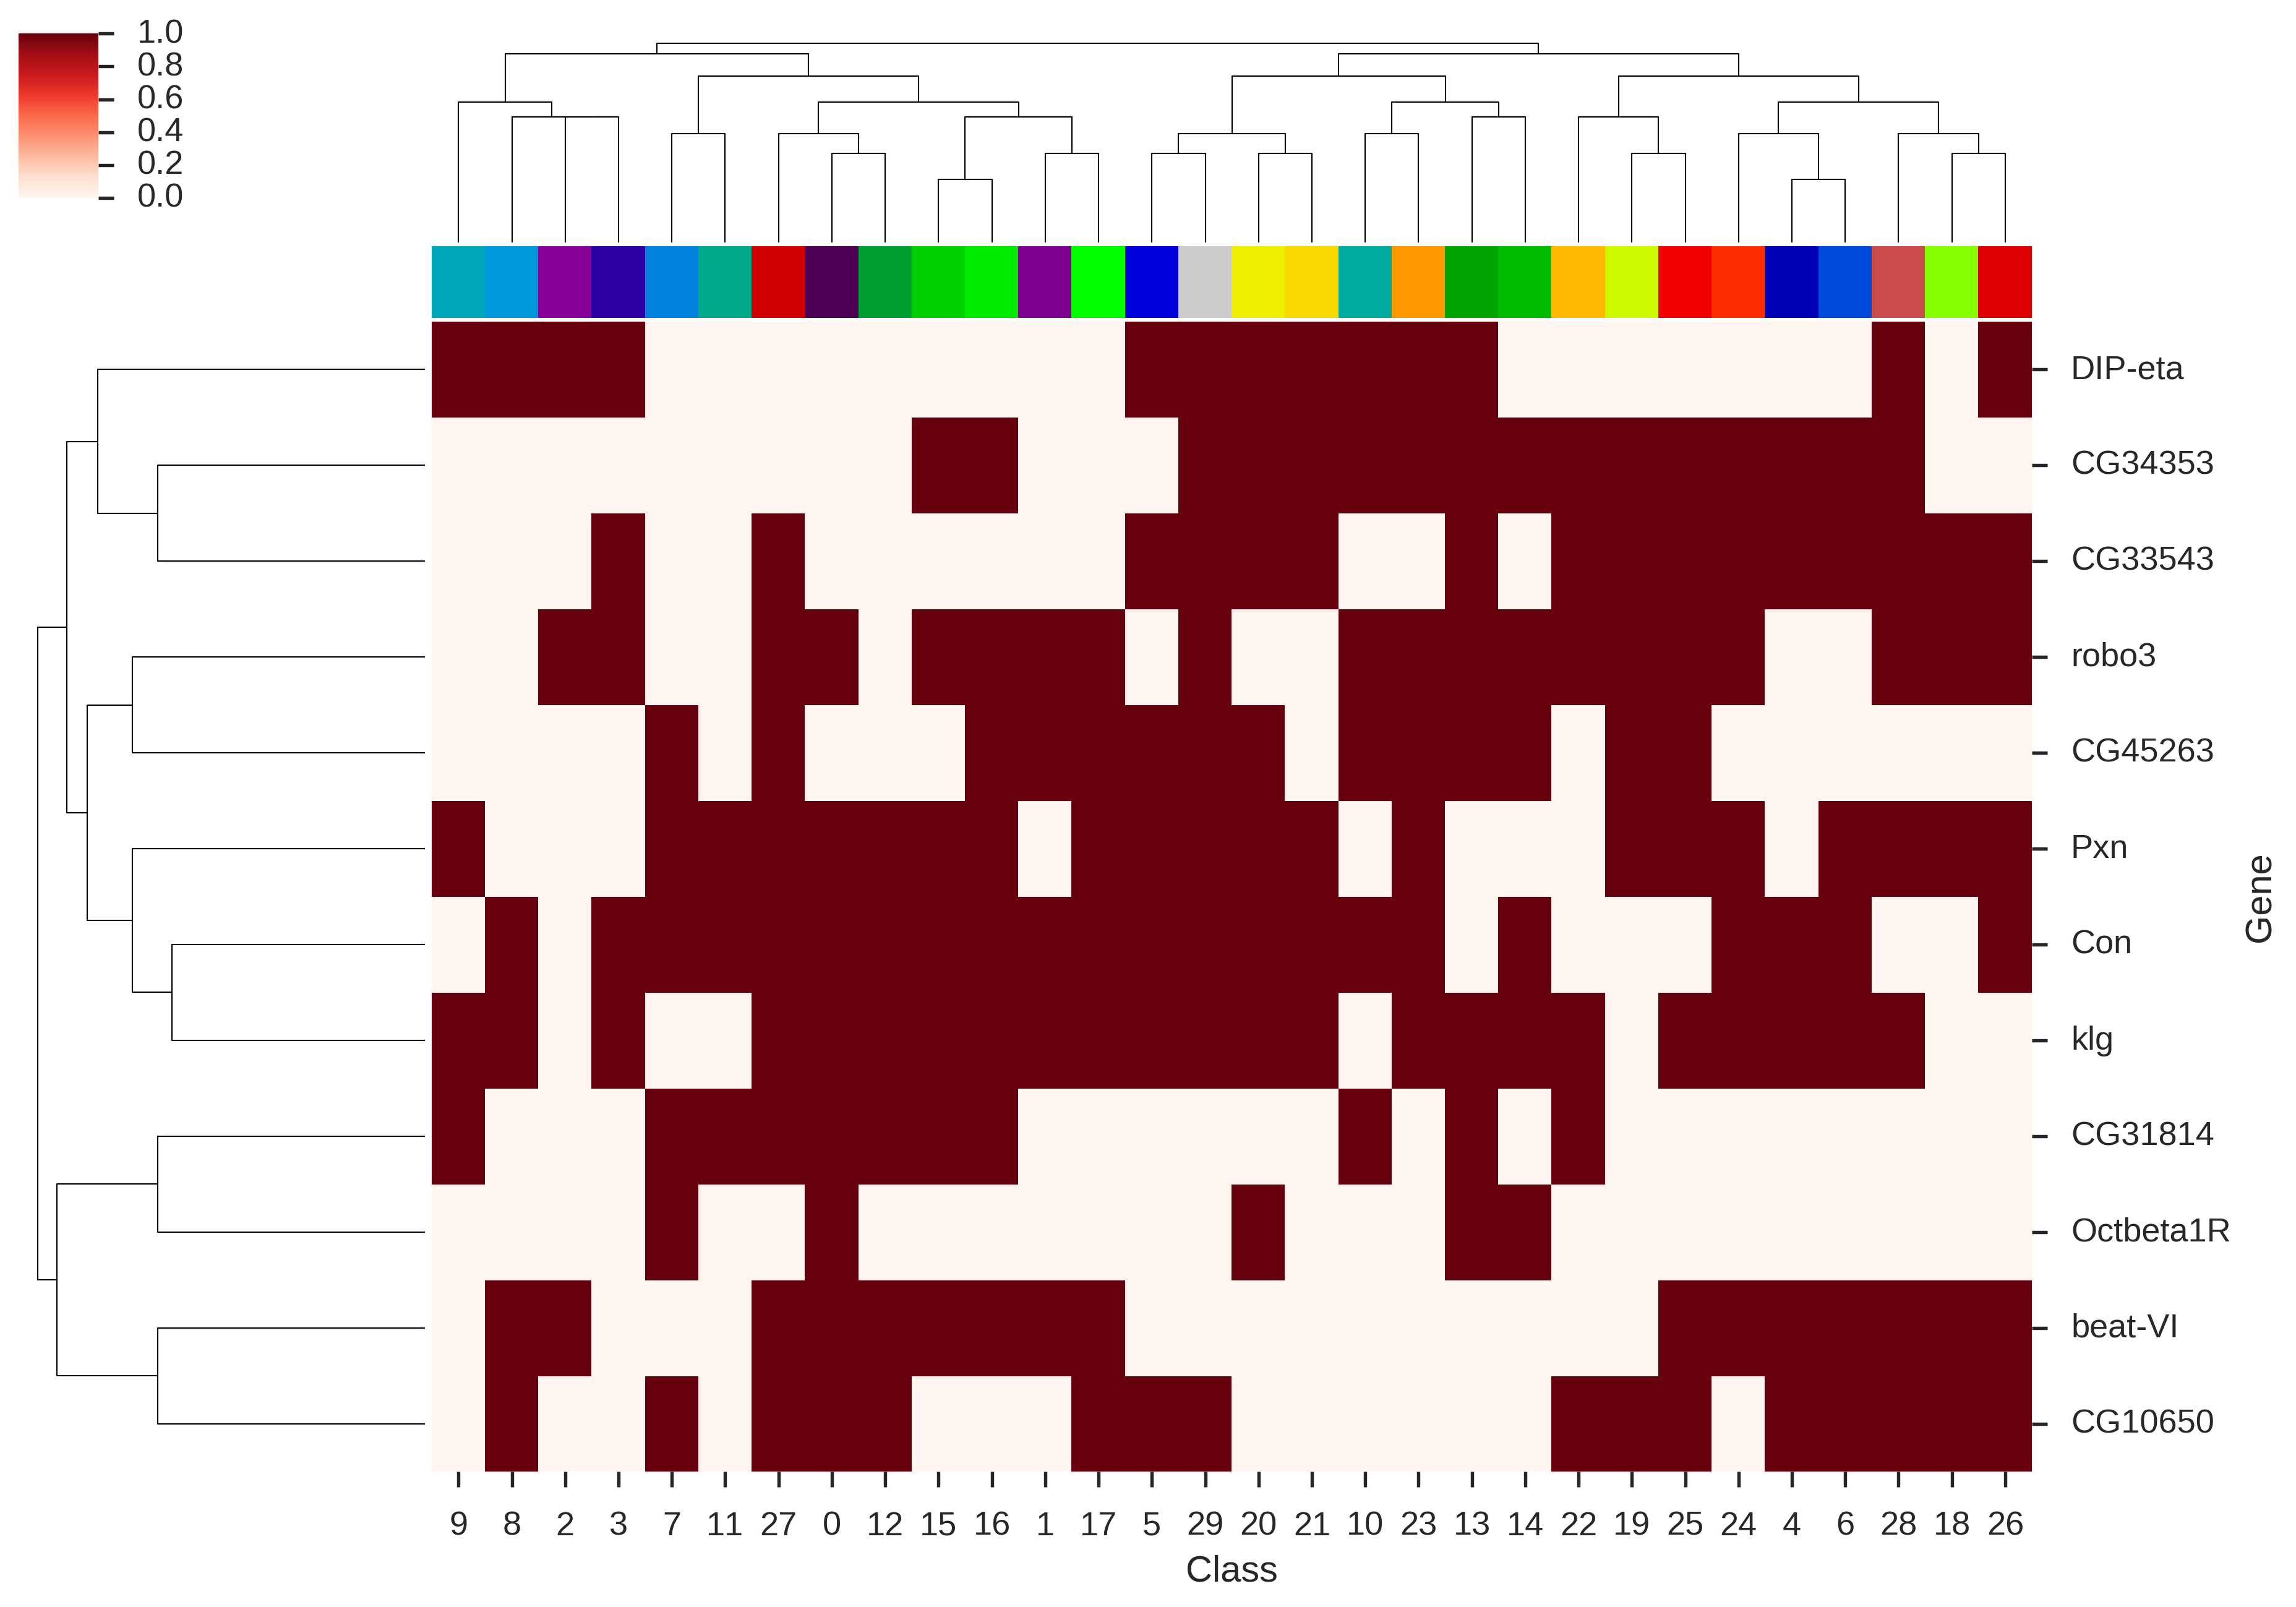

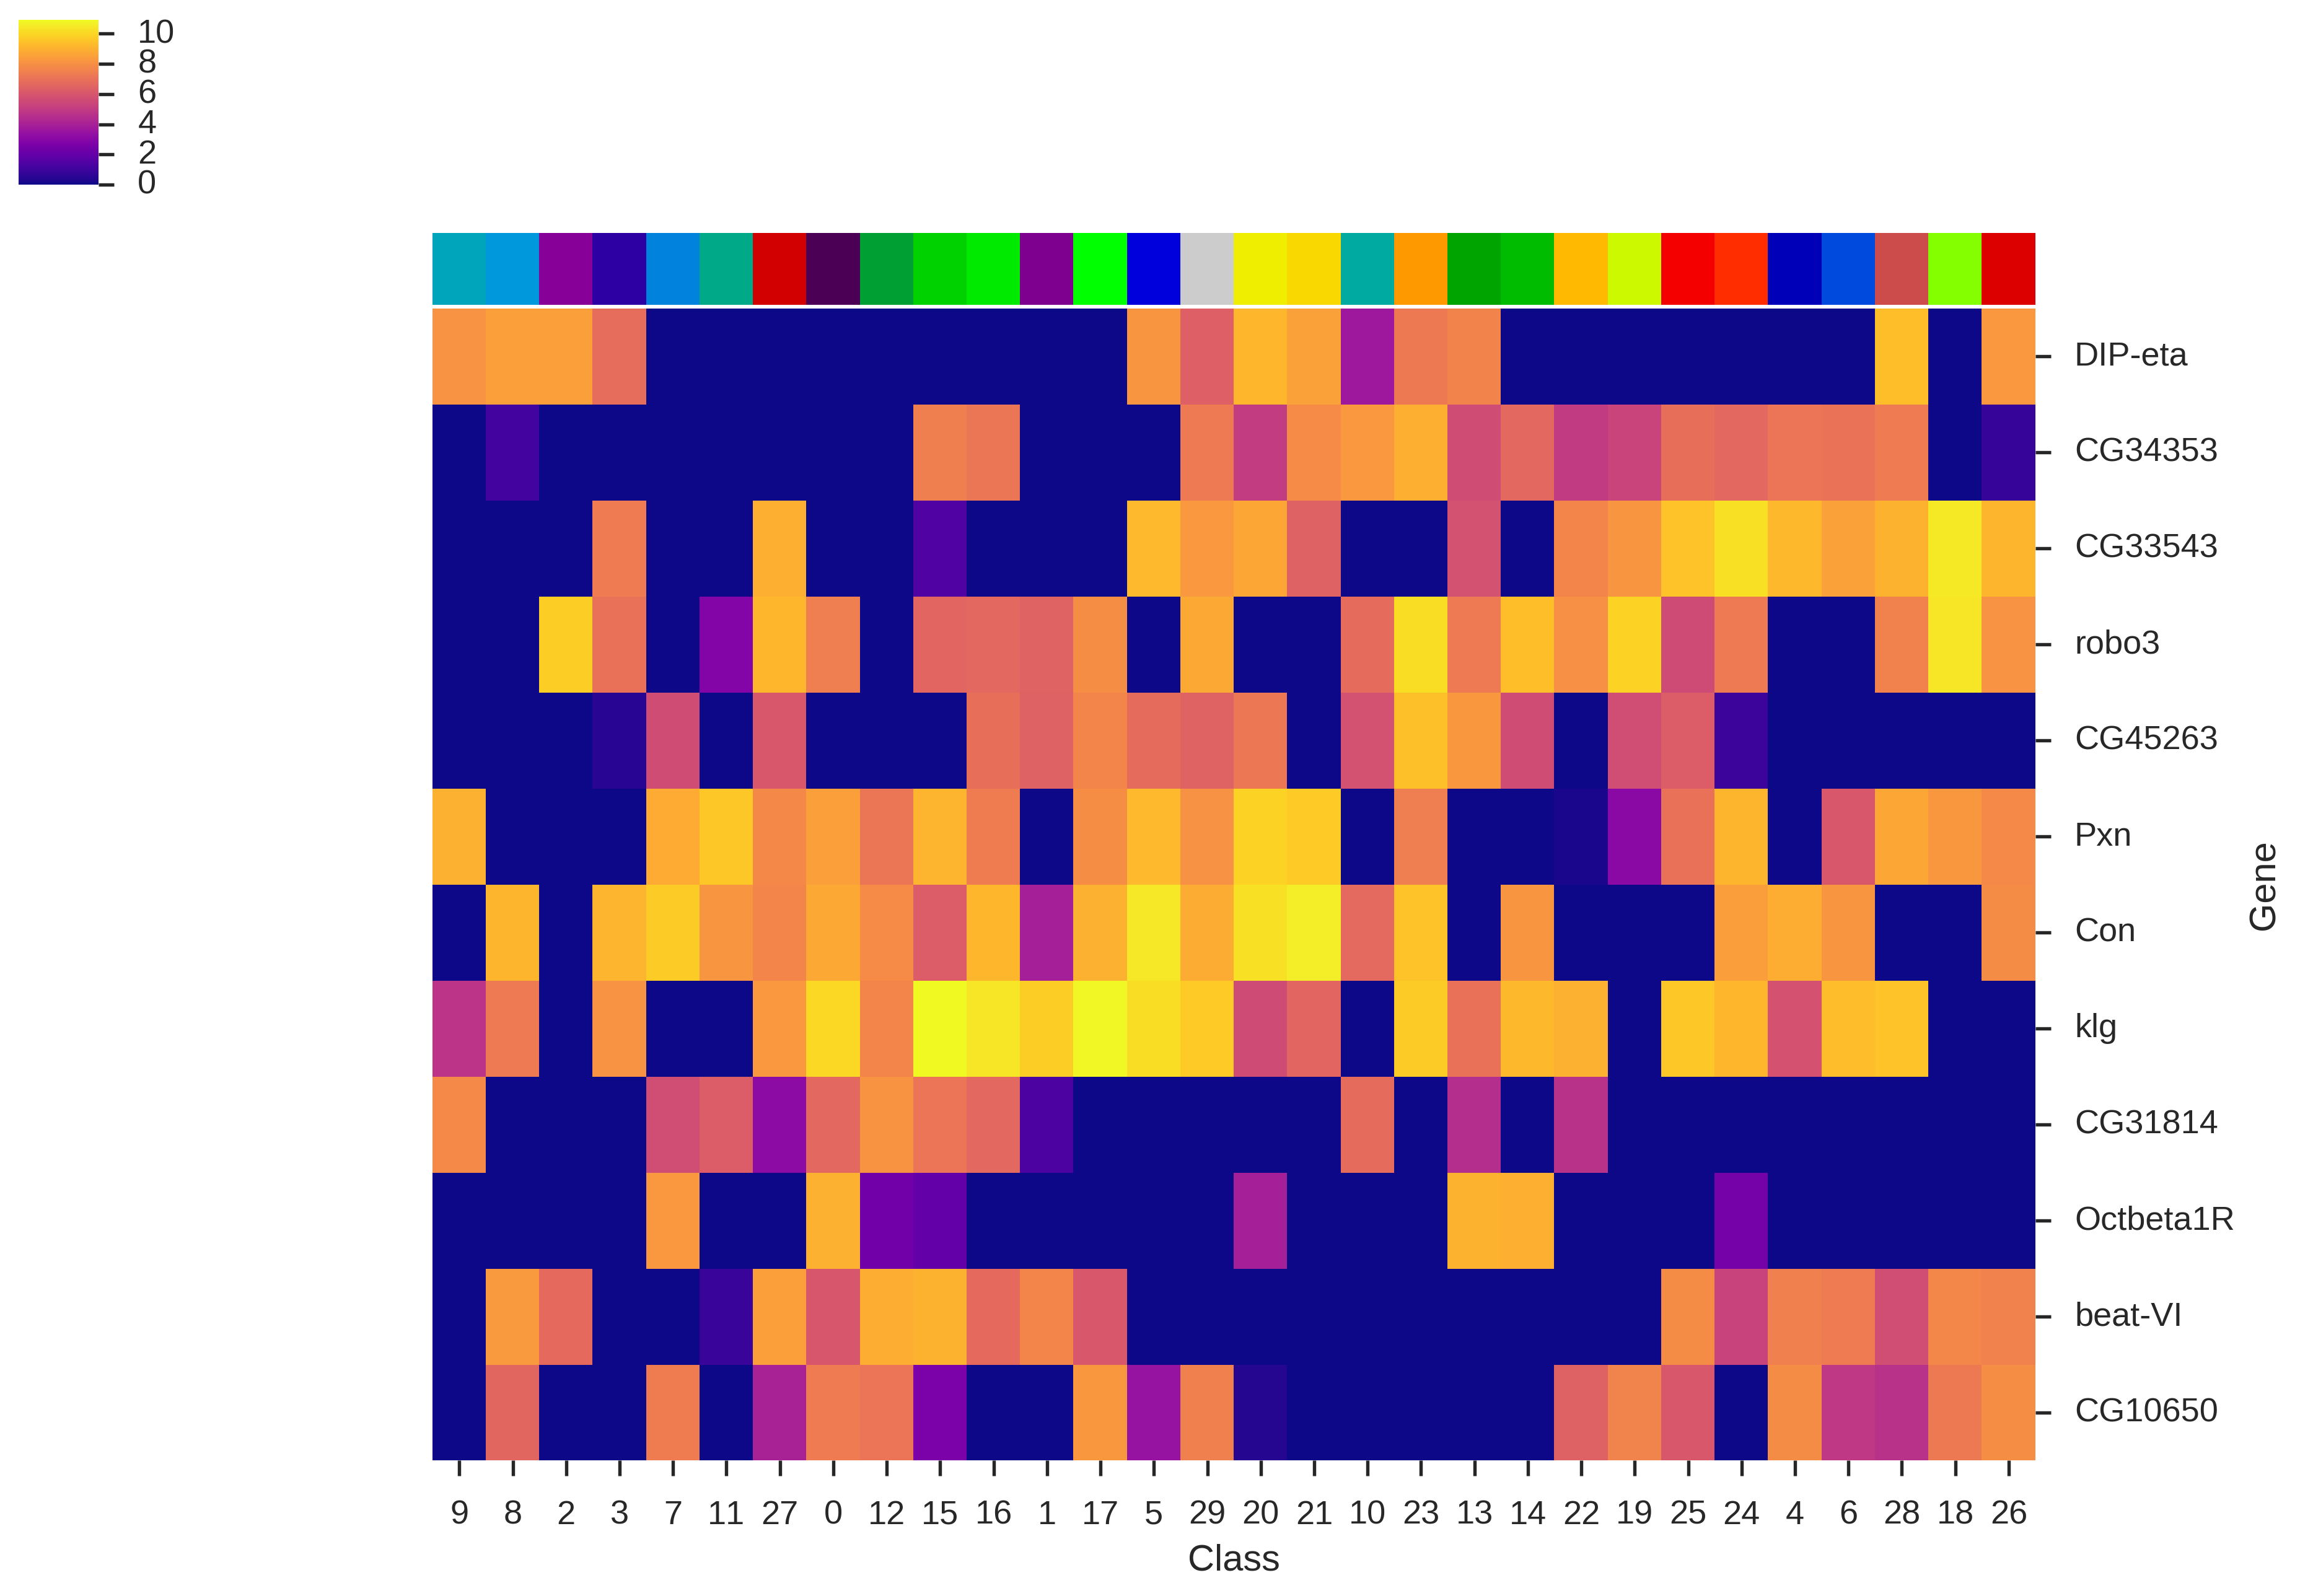

In [21]:
# Minimal set of CSMs

data = df_expr_labels.loc[genes_nonredundant_CSMs_minimal]
data = data.drop(-1, axis=1)

cmap = mpl.cm.get_cmap("nipy_spectral")
norm = mpl.colors.Normalize(vmin=min(df_labels["label"]), vmax=max(df_labels["label"]))
col_colors = [cmap(norm(x)) for x in list(data.columns)]

# Discrete
data_discrete = data > 3
cm = sns.clustermap(data=data_discrete, cmap="Reds", figsize=(14,10),
                    method="complete",
                    col_colors=col_colors)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_xlabel("Class")
cm.ax_heatmap.set_ylabel("Gene")

# Continuous, ordered same way
data_reordered = data.iloc[cm.dendrogram_row.reordered_ind, cm.dendrogram_col.reordered_ind]
col_colors = [cmap(norm(x)) for x in list(data_reordered.columns)]

cm = sns.clustermap(data=data_reordered, cmap="plasma", figsize=(14,10),
                    method="complete", row_cluster=False, col_cluster=False,
                    col_colors=col_colors)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.setp(cm.ax_heatmap.xaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_xlabel("Class")
cm.ax_heatmap.set_ylabel("Gene")

# Plot cumulative mutual information from codes of increasing size

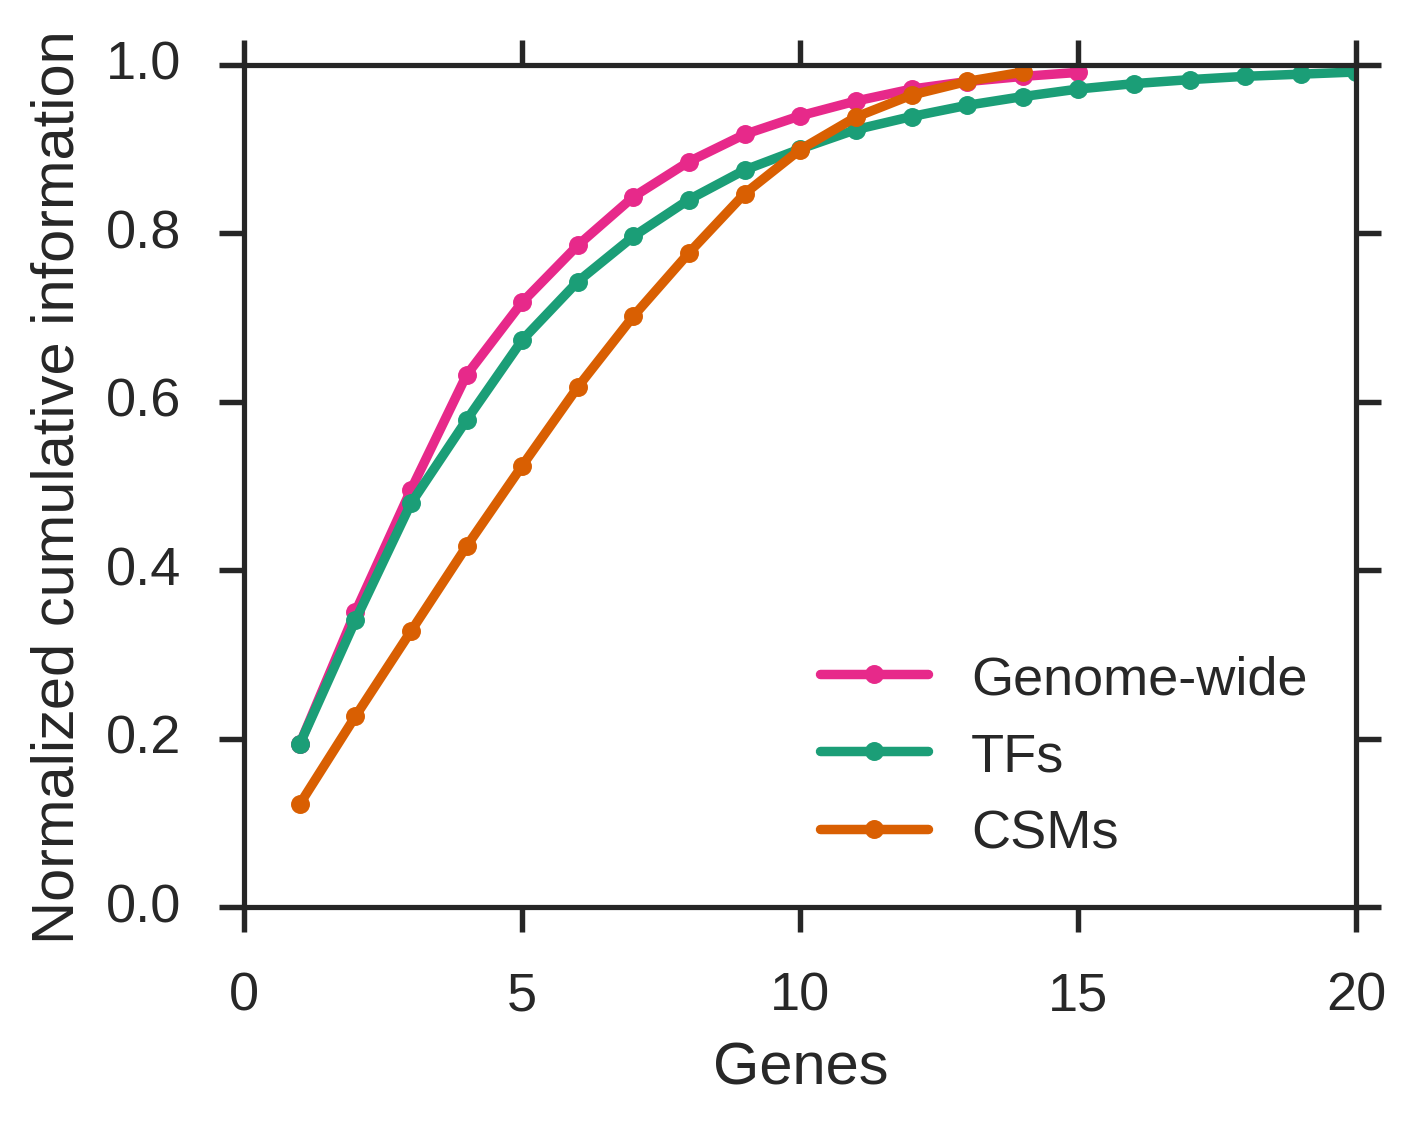

In [22]:
# Plot cumulative information

fig, ax = plt.subplots(1, 1, figsize=(5,4))

y = df_info_nonredundant.head(25)["relative_cumulative_information"].dropna()
x = range(1, len(y)+1)
ax.plot(x, y, label="Genome-wide", c="#e7298a", marker=".")

y = df_info_nonredundant_TFs.head(25)["relative_cumulative_information"]
x = range(1, len(y)+1)
ax.plot(x, y, label="TFs", c="#1b9e77", marker=".")

y = df_info_nonredundant_CSMs.head(25)["relative_cumulative_information"]
x = range(1, len(y)+1)
ax.plot(x, y, label="CSMs", c="#d95f02", marker=".")

ax.set_xlim(0,20)
ax.set_ylim(0,1)
ax.set_xlabel("Genes")
ax.set_ylabel("Normalized cumulative information")
ax.legend(loc="lower right")
plt.tight_layout()

# Compare with 1000 randomly selected genes

In [23]:
# Load info results from all replicates, record number of genes required to reach threshold information
import glob
def load_df_info_sampled(infile_basename, genes, field="relative_cumulative_information"):
    df = pd.DataFrame(index=range(40))
    infiles = glob.glob(infile_basename + "*")
    print "Files", len(infiles)
    for i, infile in enumerate(infiles):
        df_temp = pd.read_csv(infile, header=0, index_col=0)
        vals = list(df_temp[field].values)
        colname = field + str(i)
        df[colname] = np.nan
        df[colname].loc[range(len(vals))] = vals
    df.sort_index(inplace=True)
    df[field+"_mean"] = np.mean(df, axis=1)
    return df

In [24]:
df_info_nonredundant_random_sampled = load_df_info_sampled("GH146_CombinatorialCode/df_info_nonredundant_random",
                                                           genes=genes_genome_noTFs_noCSMs)

Files 100


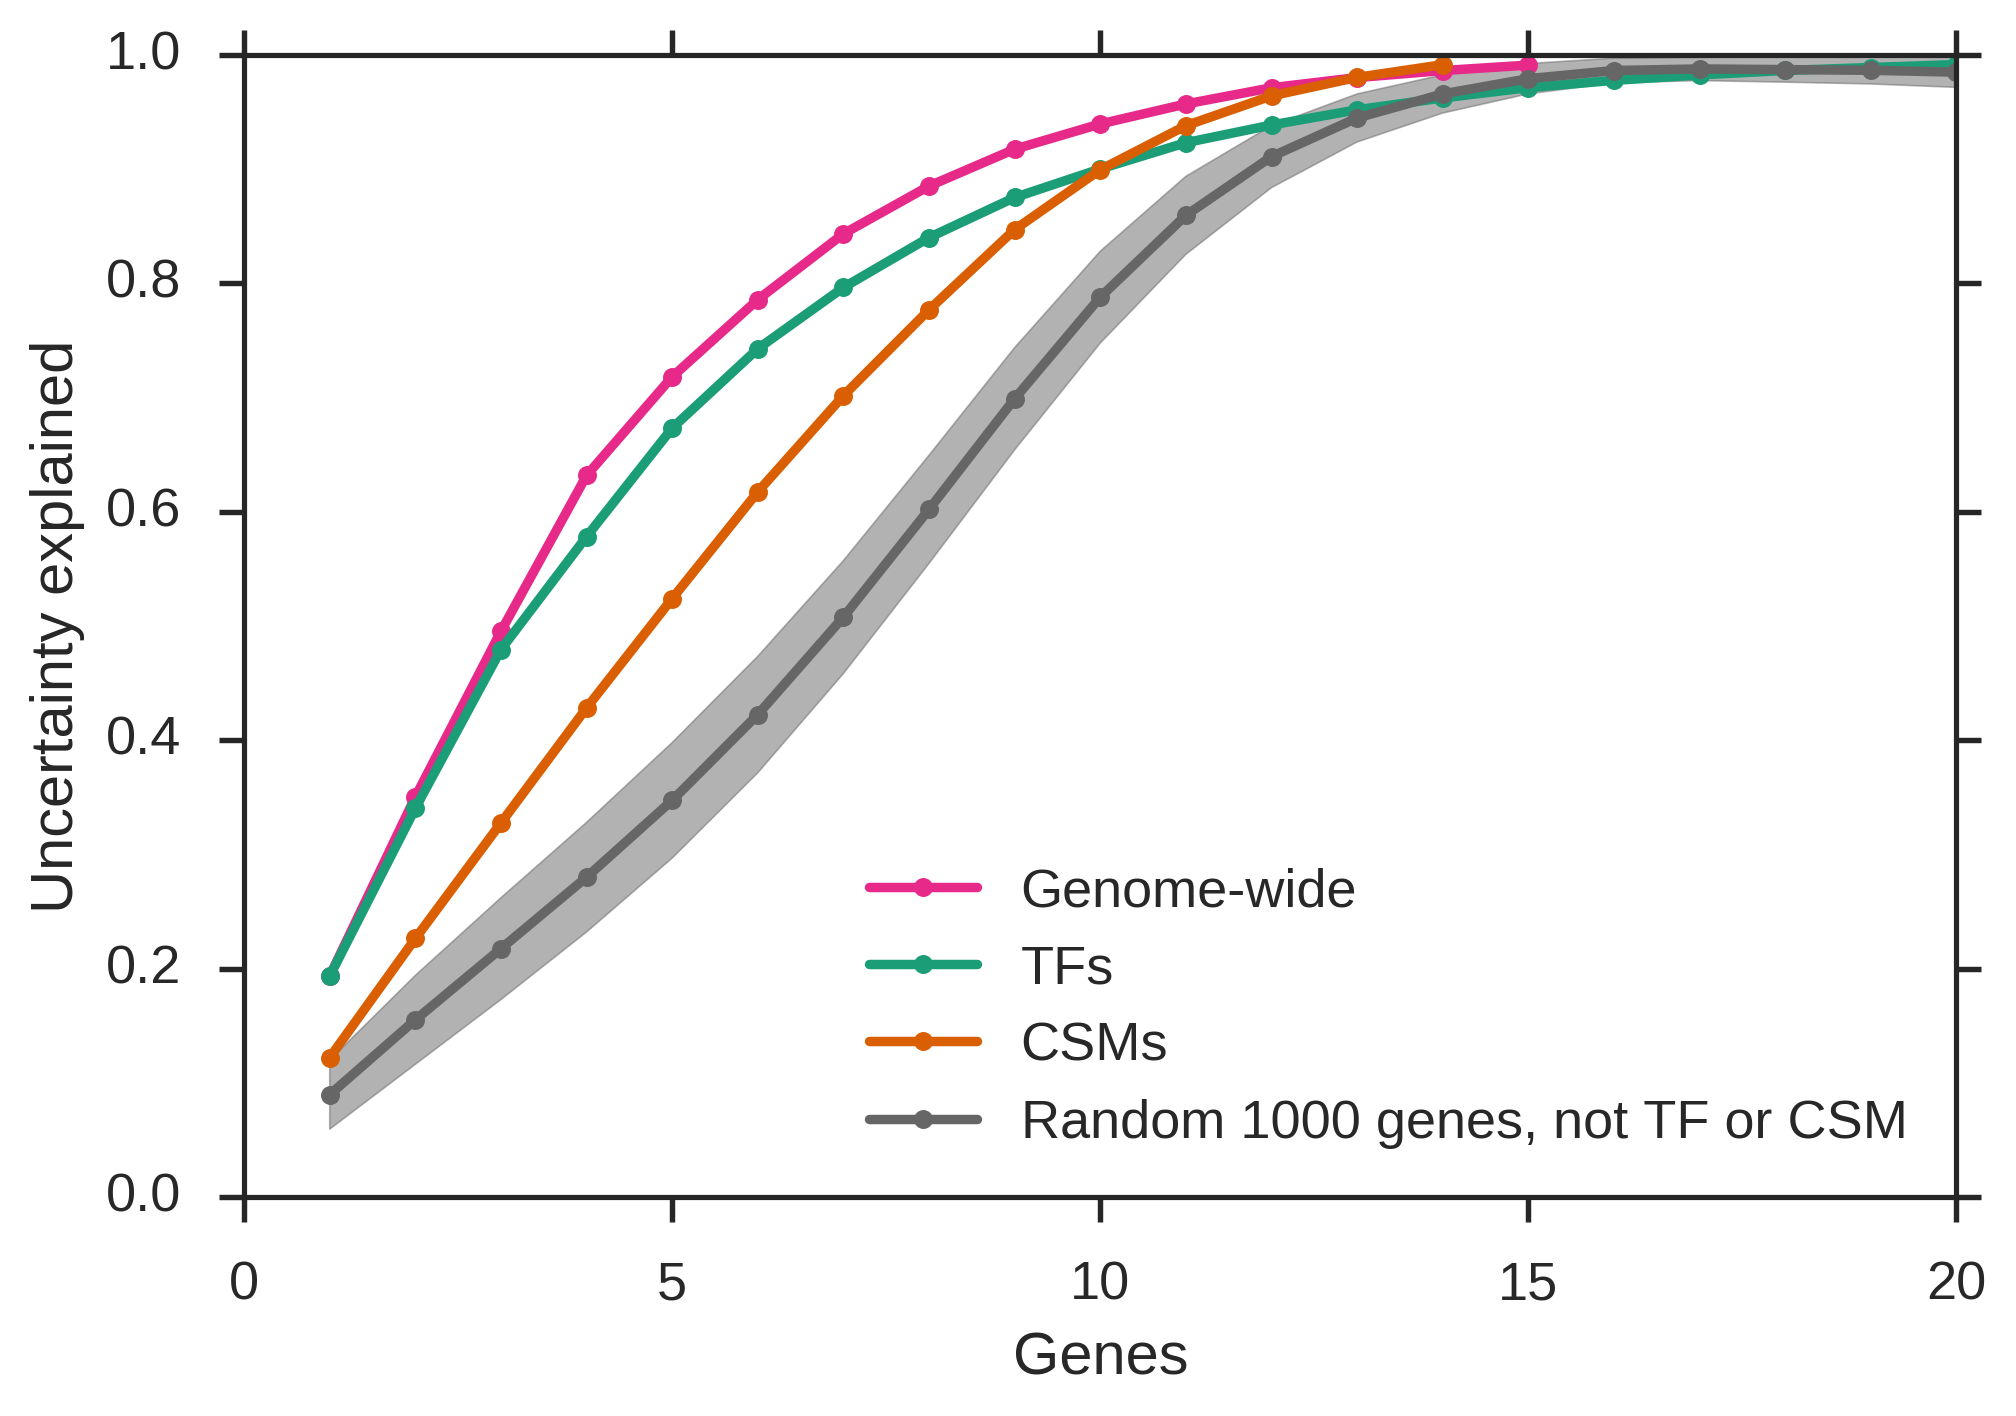

In [25]:
# Plot cumulative information including random genes

fig, ax = plt.subplots(1, 1, figsize=(7,5))

y = df_info_nonredundant.head(20)["relative_cumulative_information"].dropna()
x = range(1, len(y)+1)
ax.plot(x, y, label="Genome-wide", c="#e7298a", marker=".")

y = df_info_nonredundant_TFs.head(20)["relative_cumulative_information"]
x = range(1, len(y)+1)
ax.plot(x, y, label="TFs", c="#1b9e77", marker=".")

y = df_info_nonredundant_CSMs.head(20)["relative_cumulative_information"]
x = range(1, len(y)+1)
ax.plot(x, y, label="CSMs", c="#d95f02", marker=".")

y = df_info_nonredundant_random_sampled["relative_cumulative_information_mean"]
x = range(1, len(y)+1)
ax.plot(x, y, label="Random 1000 genes, not TF or CSM", c="#666666", marker=".")

std = np.std(df_info_nonredundant_random_sampled[range(100)], axis=1)
y+std
ax.fill_between(x, y-std, y+std, color="#666666", alpha=0.5)

ax.set_xlim(0,20)
ax.set_ylim(0,1)
ax.set_xlabel("Genes")
ax.set_ylabel("Uncertainty explained")
ax.legend(loc="lower right")
plt.tight_layout()

# Report number of genes used in various sets

In [26]:
print "Genome wide", len(list(df.index))
print "TFs", len(TFs)
print "CSMs", len(CSMs)
print "Genome wide minus TFs, CSMs", len(genes_genome_noTFs_noCSMs)

Genome wide 15522
TFs 1045
CSMs 955
Genome wide minus TFs, CSMs 13631
